In [27]:
import random
import torch
import pandas as pd
import numpy as np
import json
from torch import nn
from torch.optim import AdamW
from transformers import RobertaTokenizerFast, RobertaForTokenClassification, AutoModel
from transformers import get_scheduler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import metrics as metrics
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

random.seed(42)
reprocess_raw =  False

batch_size = 8 # documents
learning_rate = 5e-5
n_epochs = 10

# task_map = {'Quantity':1}
task_map = {'Quantity':1,'MeasuredProperty':2,'MeasuredEntity':3,'Qualifier':4} # uncomment for multi-class
num_classes = len(task_map)

model_name = 'allenai/biomed_roberta_base'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = 'cpu' # uncomment this to make debugging easier

data_size_reduce = 1 # multiplier for making small datasets



In [28]:
def read_data(reprocess_raw = False):

    currentdir = os.getcwd() # ~/MeasEval/baselines

    combopath_txt = os.path.join(currentdir, "../data/raw/combo/text/")
    combopath_annot = os.path.join(currentdir, "../data/raw/combo/tsv/")

    interimpath = os.path.join(currentdir, "../data/interim/")

    if reprocess_raw == True:
        docIds = []
        combo_txt = {}
        for fn in os.listdir(combopath_txt):
            docIds.append(fn[:-4])
            path = combopath_txt+fn
            with open(path) as textfile:
                    text = textfile.read()
                    #[:-4] strips off the .txt to get the id
                    combo_txt[fn[:-4]] = text

        combo_annot = pd.DataFrame()
        for fn in os.listdir(combopath_annot):
            path = combopath_annot+fn
            file = pd.read_csv(path,delimiter='\t',encoding='utf-8')
            combo_annot = pd.concat([combo_annot, file],ignore_index=True)

        
        with open(interimpath+'train_txt.json','w') as f:
            json.dump(train_txt, f)

        combo_annot.to_csv(interimpath+'combo_annot.csv')

        return docIds, combo_txt, combo_annot
    else:
        combo_annot = pd.read_csv(interimpath+'combo_annot.csv')

        with open(interimpath+'combo_txt.json','r') as f:
            combo_txt = json.load(f)

        docIds = list(combo_txt.keys())
    
        return docIds, combo_txt, combo_annot

In [29]:
combo_docs, combo_txt, combo_annot = read_data(reprocess_raw = reprocess_raw)

In [30]:
#### train/dev/test split options

random.seed(42)

percent_to_test = .1
percent_to_dev = .2
percent_to_train =  1 - percent_to_dev - percent_to_test

n_doc = len(combo_docs)
split_train = int(np.round(n_doc * percent_to_train))
split_dev = split_train + int(np.round(n_doc * percent_to_dev))

train_docs = combo_docs[:split_train]
dev_docs = combo_docs[split_train:split_dev]
test_docs = combo_docs[split_dev:]

train_docs = random.sample(combo_docs, int(len(combo_docs)*data_size_reduce))
dev_docs = random.sample(combo_docs, int(len(combo_docs)*data_size_reduce))
test_docs = random.sample(combo_docs, int(len(combo_docs)*data_size_reduce))

In [31]:
########## Tokenizer ###########

tokenizer = RobertaTokenizerFast.from_pretrained(model_name)

In [32]:
def process_annotation_set(annot_set):

    annot_set_processed = []

    annot_set['comboIds'] = annot_set[['docId','annotId']].agg('_'.join, axis=1)
    annot_set.set_index('comboIds',inplace=True)

    for comboId in list(annot_set.index):
        
        docId = annot_set.loc[comboId]['docId']
        annotId = annot_set.loc[comboId]['annotId']

        annotType = annot_set.loc[comboId]['annotType']
        annotSpan = [annot_set.loc[comboId]['startOffset'],annot_set.loc[comboId]['endOffset']]

        ent_annot_processed = {
            'comboId':comboId,
            'docId':docId,
            'annotId':annotId,
            'annotType':annotType,
            'annotSpan':annotSpan,
            'subSpanType':np.nan,
            'linkId':np.nan,
            'linkSpan':np.nan,
            'subSpan':np.nan,
            'unit':np.nan,
            'unitEncoded':np.nan,
            'misc':np.nan
        }
        
        other = annot_set.loc[comboId]['other']
        if isinstance(other,str):
            otherDict = json.loads(str(other))

            if annot_set.loc[comboId]['annotType'] != 'Quantity':

                ent_annot_processed['subSpanType'] = list(otherDict.keys())[0]
                link = list(otherDict.values())[0]

                ent_annot_processed['linkId'] = link
                linkIdx = docId+'_'+link
                linkSpan = [int(annot_set.loc[linkIdx]['startOffset']),int(annot_set.loc[linkIdx]['endOffset'])]
                ent_annot_processed['linkSpan'] = linkSpan

                spanEnds = annotSpan + linkSpan
                ent_annot_processed['subSpan'] = [max(spanEnds),max(spanEnds)]

            elif 'unit' in list(otherDict.keys()):
                unit = otherDict['unit']
                ent_annot_processed['unit'] = unit
                ent_annot_processed['unitEncoded'] = tokenizer.encode(unit)[1:-1]
            else:
                ent_annot_processed['misc'] = otherDict


        annot_set_processed.append(ent_annot_processed)
   
    return pd.DataFrame.from_dict(annot_set_processed).set_index('comboId')

combo_annot_processed = process_annotation_set(combo_annot)
currentdir = os.getcwd() # ~/MeasEval/baselines
combopath_annot = os.path.join(currentdir, "../data/raw/combo/tsv/")
interimpath = os.path.join(currentdir, "../data/interim/")
combo_annot_processed.to_csv(interimpath+'combo_annot_processed.csv')
combo_annot_processed.sample(7)


,docId,annotId,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,
S2213671113000921-994_T2-4,S2213671113000921-994,T2-4,MeasuredEntity,"[698, 704]",HasQuantity,T1-4,"[685, 688]","[704, 704]",NaN,NaN,NaN
S0032386113005454-2876_T3-1,S0032386113005454-2876,T3-1,MeasuredEntity,"[212, 241]",HasProperty,T4-1,"[299, 307]","[307, 307]",NaN,NaN,NaN
S0019103513005058-3094_T144-4,S0019103513005058-3094,T144-4,MeasuredProperty,"[1041, 1046]",HasQuantity,T114-4,"[1028, 1040]","[1046, 1046]",NaN,NaN,NaN
S0167880913001229-1304_T3-5,S0167880913001229-1304,T3-5,MeasuredEntity,"[357, 377]",HasProperty,T2-5,"[469, 470]","[470, 470]",NaN,NaN,NaN
S0019103512003995-1910_T228-8,S0019103512003995-1910,T228-8,MeasuredProperty,"[446, 461]",HasQuantity,T58-8,"[493, 504]","[504, 504]",NaN,NaN,NaN
S0019103511004994-1382_T52-2,S0019103511004994-1382,T52-2,Quantity,"[426, 434]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0960148113005727-855_T3-2,S0960148113005727-855,T3-2,MeasuredProperty,"[216, 236]",HasQuantity,T1-2,"[252, 257]","[257, 257]",NaN,NaN,NaN


In [33]:
### insert special tokens for subspans (Sam)
# will make docs longer

# def char_map(doc_annot, task_map)


def tokenize_and_align_labels(
                                doc_list=combo_docs,
                                txt=combo_txt,
                                processed_annotation=combo_annot_processed,
                                tokenizer=tokenizer,
                                taskLabelMap=task_map
                            ):

    toks_with_labels = []
    special_ids = tokenizer.all_special_ids

    for doc in doc_list:
        # print(doc)
        # print(processed_annotation.loc[processed_annotation['docId'] == doc])
        doc_annot = processed_annotation.loc[processed_annotation['docId'] == doc]
        doc_annot.set_index('annotId',inplace=True)
        # print(doc_annot)

        encoded_txt = tokenizer(txt[doc], padding='max_length', max_length=512, truncation=True)
        encoded_tokens = encoded_txt['input_ids']
        # print(encoded_tokens)

        ############### Label Primary Spans ###############

        labelIds = np.full(len(encoded_tokens),-1)
        taskCharMap = {} # 
        taskCharList = []
        taskAnnotIdCharMap = {} # to check for token collision
        
        for task in list(taskLabelMap.keys()):
            #print(task)
            annotId = doc_annot.loc[doc_annot['annotType']==task].index
            # print(annotId)
            spans = list(doc_annot.loc[doc_annot['annotType']==task]['annotSpan'])
            # print(spans)
            for span in spans:
                # print(span)
                span = list(range(span[0],span[-1]))
                # print(span)
                for spanCharIdx in span:
                    # print(spanCharIdx)
                    taskCharMap[spanCharIdx] = taskLabelMap[task]
                # print(taskCharMap)
                    # taskAnnotIdCharMap[spanCharIdx] = annotId

        decoded = [''] * len(encoded_tokens)
        for tokenIdx, token in enumerate(encoded_tokens):
            
            if token not in special_ids:
                tokenCharStart = encoded_txt.token_to_chars(tokenIdx).start
                if tokenCharStart in list(taskCharMap.keys()):
                    labelIds[tokenIdx] = taskCharMap[tokenCharStart]
                    decoded[tokenIdx] = tokenizer.decode(token)
                else:
                    labelIds[tokenIdx] = 0
            else:
                labelIds[tokenIdx] = 0
        

        ############### Sub Spans Token Insertion and labeling ###############

        encoded_txt['doc_or_sent_id'] = doc
        encoded_txt['labels'] = labelIds
        
        toks_with_labels.append(encoded_txt)
    
    # return toks_with_labels
    return pd.DataFrame.from_dict(toks_with_labels)

In [34]:
################# TOKENIZE #################

stage1_train_ds = tokenize_and_align_labels(
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_train_ds.to_csv(interimpath+'stage1_train_ds.csv')
stage1_n_train = stage1_train_ds.shape[0]


stage1_dev_ds = tokenize_and_align_labels(
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_dev_ds.to_csv(interimpath+'stage1_dev_ds.csv')
stage1_n_dev = stage1_dev_ds.shape[0]

stage1_test_ds = tokenize_and_align_labels(
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_test_ds.to_csv(interimpath+'stage1_test_ds.csv')
stage1_n_test = stage1_test_ds.shape[0]


In [35]:
### Matt
# def shorten_txt_encoding(txt, shorten_by : int):       
#     pass...

# generate a list of docIds that have token collision after shortening

toks = list(stage1_dev_ds.loc[stage1_dev_ds['doc_or_sent_id']=='S0022000014000026-18167']['input_ids'])

print(toks[0])

tokenizer.decode(toks[0])

[0, 1620, 5, 6427, 9, 84, 2225, 6, 52, 122, 7118, 7, 61, 5239, 5, 3611, 9, 84, 5574, 9, 5, 39189, 2118, 2744, 17194, 6, 61, 33, 57, 2327, 8, 13031, 624, 84, 19039, 7208, 8, 4776, 9280, 2368, 6, 972, 84, 1521, 1175, 4, 9870, 6, 52, 40, 2268, 10, 346, 9, 801, 5139, 8, 499, 557, 19922, 4, 1541, 43733, 40, 1407, 5, 25212, 8608, 3147, 11, 7162, 132, 4, 134, 4, 406, 4, 21438, 42895, 4850, 35, 286, 10, 10686, 5574, 6, 5, 746, 346, 9, 14213, 16, 384, 1640, 35760, 18857, 43, 228, 37908, 4, 152, 64, 28, 450, 30, 21981, 14, 5, 13879, 9, 5, 11543, 14213, 16, 17349, 5, 25, 8307, 3320, 13510, 346, 9, 14213, 6, 187, 5, 384, 1640, 282, 43, 2405, 6411, 9, 10, 37908, 33, 10, 5891, 346, 9, 14213, 349, 131, 634, 28662, 4836, 7, 5731, 11543, 14213, 6, 5, 2305, 13879, 8191, 3905, 646, 3818, 8174, 6892, 705, 11416, 6, 42, 346, 9, 14213, 16, 10, 3724, 9, 384, 1640, 462, 18857, 43, 31, 19329, 4, 166, 43132, 14, 11, 754, 42, 13879, 16, 25, 8307, 3320, 1242, 3435, 19329, 6, 3867, 65, 16, 2882, 7, 9802, 97, 21453

'<s>As the conclusion of our paper, we now assess to which extent the properties of our implementation of the FATAL+ algorithm, which have been expressed and verified within our modeling framework and tested experimentally, meet our design goals. Furthermore, we will discuss a number of potential improvements and future research avenues. Our exposition will follow the optimization criteria listed in Section 2.1.7.•Area consumption: For a suitable implementation, the total number of gates is O(nlogn) per node. This can be seen by observing that the complexity of the threshold gates is dominating the asymptotic number of gates, since the O(n) remaining components of a node have a constant number of gates each; using sorting networks to implement threshold gates, the stated complexity bound follows [48]. Trivially, this number of gates is a factor of O(logn) from optimal. We conjecture that in fact this complexity is asymptotically optimal, unless one is willing to sacrifice other desirab

In [36]:
def batchify(tokenized_dataset, batch_size, device):
    num_examples = int(tokenized_dataset.shape[0] / batch_size)
    batch_sizes = [batch_size for x in range(num_examples)]
    last_batch_size = tokenized_dataset.shape[0] % batch_size
    if last_batch_size:
        batch_sizes.append(last_batch_size)
    # print(batch_sizes)

    batched_dataset = []

    for idx, size in enumerate(batch_sizes):
        start = sum(batch_sizes[:idx])
        end = sum(batch_sizes[:idx]) + size - 1
        # print(start,end,idx)
        input_ids = torch.LongTensor(tokenized_dataset['input_ids'].loc[start:end].tolist()).to(device)
        attention_mask = torch.LongTensor(tokenized_dataset['attention_mask'].loc[start:end].tolist()).to(device)
        labels = torch.LongTensor(tokenized_dataset['labels'].loc[start:end].tolist()).to(device)
        # print(labels.shape)
        # doc_or_sent_id = list(tokenized_dataset['doc_or_sent_id'].loc[start:end])
        
        batch = {
            'input_ids':input_ids,
            'labels':labels,
            'attention_mask':attention_mask,
            # 'doc_or_sent_id':doc_or_sent_id

        }
        
        batched_dataset.append(batch)

    return batched_dataset

In [37]:
################# batchify ####################

batched_train_ds = batchify(stage1_train_ds[['attention_mask','input_ids','labels']], batch_size, device)
batched_dev_ds = batchify(stage1_dev_ds[['attention_mask','input_ids','labels']], batch_size, device)
batched_test_ds = batchify(stage1_test_ds[['attention_mask','input_ids','labels']], batch_size, device)


In [38]:
class Stage1model(nn.Module):
    def __init__(self, dropout=0.1):
        super(Stage1model, self).__init__()
        self.roberta = RobertaForTokenClassification.from_pretrained(model_name,
                        num_labels=num_classes,
                        hidden_dropout_prob=0.5)
        self.drop = nn.Dropout(self.roberta.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_classes+1)

    def forward(self, input_ids, attention_mask):
        batch_size, num_tokens = input_ids.shape
        token_type = torch.zeros((batch_size, num_tokens), dtype=torch.long).to(device)
        output = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type,
            output_hidden_states=True)
        return self.classifier(self.drop(output.hidden_states[12]))

model = Stage1model()

print(sum(p.numel() for p in model.parameters()),"parameters!")
model = model.to(device)
print("Detected", torch.cuda.device_count(), "GPUs!")

criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = AdamW(model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at allenai/biomed_roberta_base were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on

124061961 parameters!
Detected 1 GPUs!


In [39]:
model.roberta.config

RobertaConfig {
  "_name_or_path": "allenai/biomed_roberta_base",
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.5,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [40]:
def train_epoch(model, ds, criterion):

    model.train()

    ypred = []
    ytrue = []
    for idx, batch in enumerate(ds):

        labels = batch['labels']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask).permute(0,2,1)
        
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()

        progress_bar.update(1)
            
    return loss.item()



def eval_epoch(model, ds, criterion):

    model.eval()

    ypred = []
    ytrue = []
    with torch.no_grad():
        for idx, batch in enumerate(ds):

            labels = batch['labels']
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            logits = model(input_ids, attention_mask).permute(0,2,1)

            loss = criterion(logits, labels)

            for dlogits, dlabels in zip(logits, labels):
                    for tlogits, tlabels in zip(dlogits, dlabels):
                        ypred.append(tlogits.argmax().item())
                        ytrue.append(tlabels.item())

        progress_bar.update(1)

    acc = metrics.accuracy_score(ytrue,ypred)
    report = classification_report(ytrue,ypred,
                                    labels=list(task_map.values()),
                                    target_names=list(task_map.keys()),
                                    output_dict=True,
                                    zero_division=0)

                                    

    return loss.item(), acc, report, ytrue, ypred

In [41]:
print(batched_train_ds[0]['labels'].cpu().numpy()[0])

[0 0 0 0 0 0 3 3 3 3 0 3 3 0 1 0 3 3 3 3 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 3 3 3 0 2 2 1 1 1 1 0 1 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3
 3 3 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [42]:
input_ids = batched_train_ds[0]['input_ids'].cpu().numpy()[0]
labels = batched_train_ds[0]['labels'].cpu().numpy()[0]

labeled_tokens = ''
for id, lab in zip(input_ids, labels):
    if lab:
        labeled_tokens = labeled_tokens + tokenizer.decode(id) + ' '
print(labeled_tokens)

 White hall  II  study  baseline  examination  1991  follow - up  screenings  1997 ,  2003 ,  and  2008  53 18  participants mean  age  54 . 8  years  31 %  women  Center  for  Epidem i ologic  Studies  Depression  Scale  score  ≥ 16 


In [43]:

num_epochs = n_epochs
num_training_steps = num_epochs * len(batched_train_ds)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

run_report = {  'epoch':[],
                'train_loss':[],
                'eval_train_loss':[],
                'eval_train_acc':[],
                'eval_train_ytrue':[],
                'eval_train_ypred':[],
                'eval_train_rpt':[],
                'eval_dev_loss':[],
                'eval_dev_acc':[],
                'eval_dev_ytrue':[],
                'eval_dev_ypred':[],
                'eval_dev_rpt':[],
             }

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    run_report['epoch'].append(epoch)
    
    print(f"\n============ Begin Epoch {epoch+1} ============")

    loss = train_epoch(model, batched_train_ds, criterion)
    print(f"Train loss: {loss}")
    run_report['train_loss'].append(loss)
    
    output = eval_epoch(model, batched_train_ds, criterion)
    (loss, acc, report, ytrue, ypred) = output
    print(f'Eval on train set loss: {loss}   accuracy: {acc}')
    run_report['eval_train_loss'].append(loss)
    run_report['eval_train_acc'].append(acc)
    run_report['eval_train_ytrue'].append(ytrue)
    run_report['eval_train_ypred'].append(ypred)
    run_report['eval_train_rpt'].append(report)

    output = eval_epoch(model, batched_dev_ds, criterion)
    (loss, acc, report, ytrue, ypred) = output
    print(f'Eval on dev set loss: {loss}   accuracy: {acc}')
    run_report['eval_dev_loss'].append(loss)
    run_report['eval_dev_acc'].append(acc)
    run_report['eval_dev_ytrue'].append(ytrue)
    run_report['eval_dev_ypred'].append(ypred)
    run_report['eval_dev_rpt'].append(report)
    

# run_report = pd.DataFrame.from_dict(run_report)

  0%|          | 0/560 [00:00<?, ?it/s]


============ Begin Epoch 1 ============
Train loss: 929.5193481445312
Eval on train set loss: 1109.0225830078125   accuracy: 0.10357142857142858
Eval on dev set loss: 1109.022705078125   accuracy: 0.10357142857142858

============ Begin Epoch 2 ============
Train loss: 818.07861328125
Eval on train set loss: 927.3742065429688   accuracy: 0.10089285714285715
Eval on dev set loss: 927.3742065429688   accuracy: 0.10089285714285715

============ Begin Epoch 3 ============
Train loss: 722.172607421875
Eval on train set loss: 698.7689208984375   accuracy: 0.026785714285714284
Eval on dev set loss: 698.7689208984375   accuracy: 0.026785714285714284

============ Begin Epoch 4 ============
Train loss: 589.8447875976562
Eval on train set loss: 513.8783569335938   accuracy: 0.008482142857142856
Eval on dev set loss: 513.8783569335938   accuracy: 0.008482142857142856

============ Begin Epoch 5 ============
Train loss: 500.6436767578125
Eval on train set loss: 444.95904541015625   accuracy: 0.00

In [ ]:
##### todo: save reports and results to files

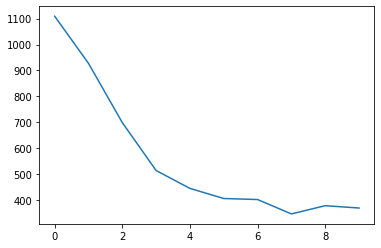

In [44]:
########################## training loss plot #######################

import matplotlib.pyplot as plt
x = np.array(range(len(run_report['epoch'])))
y = np.array(run_report['eval_dev_loss'])
plt.plot(x,y)
plt.show()

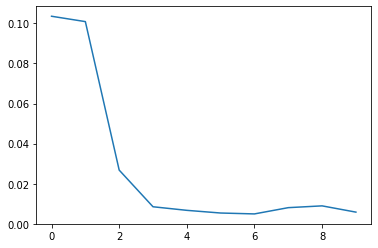

In [45]:
########################## eval loss plot #######################

import matplotlib.pyplot as plt
x = np.array(range(len(run_report['epoch'])))
y = np.array(run_report['eval_dev_acc'])
plt.plot(x,y)
plt.show()